In [5]:
# Polyp Segmentation
# Architecture: Res-UNet
# Dataset: Kvasir-SEG

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split


# OpenCV
import cv2

# Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
#@title PolypDataset
class PolypDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

        # Get all image files
        self.images_dir = os.path.join(data_dir, 'images')
        self.masks_dir = os.path.join(data_dir, 'masks')

        # Get all image files
        self.images_filenames = os.listdir(self.images_dir)
        self.masks_filenames = os.listdir(self.masks_dir)

        # Sort all image files
        self.images_filenames.sort()
        self.masks_filenames.sort()

        # Define transformations
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.7),
            A.Resize(128, 128),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        # Read image and mask
        image_path = os.path.join(self.images_dir, self.images_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_filenames[idx])

        # Read image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply augmentations
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image'] # [3, 256, 256]
        mask = transformed['mask'] # [256, 256]

        # Add a channel dimension to masks
        mask = mask.unsqueeze(0) # [1, 256, 256]

        # Convert mask and image to float tensors
        mask = mask.float()
        image = image.float()

        # Normalize image
        image = image / 255.0
        mask = mask / 255.0

        return {
            'image': image, # [3, 256, 256]
            'mask': mask # [1, 256, 256]
        }

In [7]:
#@title Split Dataset
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Split dataset into train, validation and test sets

    Args:
        dataset (Dataset): dataset to split
        train_ratio (float, optional): ratio of train set. Defaults to 0.8.
        val_ratio (float, optional): ratio of validation set. Defaults to 0.1.
        test_ratio (float, optional): ratio of test set. Defaults to 0.1.
        seed (int, optional): random seed. Defaults to 42.
    Returns:
        train_dataset, val_dataset, test_dataset: train, validation and test sets
    """
    assert (train_ratio + val_ratio + test_ratio) == 1

    # Set seed
    torch.manual_seed(seed)

    # Get dataset size
    dataset_size = len(dataset)

    # Split dataset
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset


In [8]:
#@title Visualize Dataset
# def visualize_dataset(dataset, idx=0):
#     # Get image and mask
#     sample = dataset[idx]
#     image, mask = sample['image'], sample['mask']

#     # Convert mask to RGB
#     mask = mask.repeat(3, 1, 1)

#     # Visualize image and mask
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     ax[0].imshow(image.permute(1, 2, 0))
#     ax[0].set_title('Image')

#     ax[1].imshow(mask.permute(1, 2, 0))
#     ax[1].set_title('Mask')

#     plt.show()

In [9]:
#@title ResUNet building blocks

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=output_dim,
                kernel_size=3,
                stride=stride,
                padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=output_dim,
                out_channels=output_dim,
                kernel_size=3,
                padding=1
            )
        )

        self.conv_skip = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=output_dim,
                kernel_size=3,
                stride=stride,
                padding=1
            ),
            nn.BatchNorm2d(output_dim)
        )

    def forward(self, x):
        x1 = self.conv_block(x)
        x2 = self.conv_skip(x)

        return x1 + x2


class UpSample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(UpSample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            in_channels=input_dim,
            out_channels=output_dim,
            kernel_size=kernel,
            stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

In [10]:
#@title ResUNet model
class ResUNet(nn.Module):
    def __init__(self, channel, filters = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=channel,
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=filters[0],
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            )
        )

        self.input_skip = nn.Sequential(
            nn.Conv2d(
                in_channels=channel,
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            )
        )

        self.residual_conv1 = ResidualConv(filters[0], filters[1], stride=2, padding=1)
        self.residual_conv2 = ResidualConv(filters[1], filters[2], stride=2, padding=1)

        self.bridge = ResidualConv(filters[2], filters[3], stride=2, padding=1)

        self.upsample1 = UpSample(filters[3], filters[3], kernel=2, stride=2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], stride=1, padding=1)

        self.upsample2 = UpSample(filters[2], filters[2], kernel=2, stride=2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], stride=1, padding=1)

        self.upsample3 = UpSample(filters[1], filters[1], kernel=2, stride=2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], stride=1, padding=1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=filters[0],
                out_channels=1,
                kernel_size=1
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv1(x1)
        x3 = self.residual_conv2(x2)

        # Bridge
        x4 = self.bridge(x3)

        # Decoder
        x4 = self.upsample1(x4)

        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        # Output
        x11 = self.output_layer(x10)

        return x11

In [40]:
#@title BCEDiceLoss
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()

    def forward(self, input, target):
        # input: [batch_size, 1, height, width]
        # target: [batch_size, 1, height, width]

        pred = input.view(-1)
        truth = target.view(-1)

        # BCE Loss
        bce_loss = nn.BCELoss()(pred, truth).double() # double() for numerical stability

        # Dice Loss
        dice_coeff = (2.0 * (pred * truth).double().sum() + 1.0) / (pred.double().sum() + truth.double().sum() + 1.0)

        return 0.1 * bce_loss + 0.9 * (1.0 - dice_coeff)


In [41]:
#@title Metrics

def jaccard_index(input, target):
    """
    Computes the Jaccard index between input and target tensors.

    Args:
        input (torch.Tensor): Input tensor with shape [batch_size, 1, height, width]
        target (torch.Tensor): Target tensor with shape [batch_size, 1, height, width]

    Returns:
        float: Jaccard index value
    """
    intersection = torch.sum(input * target).item()
    union = torch.sum(input) + torch.sum(target) - intersection

    if union == 0:
        return float("nan")
    else:
        return float(intersection) / float(max(union, 1))

def dice_coeff(input, target):
    """
    Computes the Dice coefficient between input and target tensors.

    Args:
        input (torch.Tensor): Input tensor with shape [batch_size, 1, height, width]
        target (torch.Tensor): Target tensor with shape [batch_size, 1, height, width]

    Returns:
        float: Dice coefficient value
    """
    smooth = 1.0

    num = input.size(0)

    pred = input.view(num, -1)
    truth = target.view(num, -1)

    intersection = torch.sum(pred * truth, dim=1)
    dice = (2.0 * intersection + smooth) / (torch.sum(pred, dim=1) + torch.sum(truth, dim=1) + smooth)

    return dice.mean().item()


In [42]:
#@title Trainer
class Trainer:
    def __init__(
            self,
            model,
            criterion,
            optimizer,
            scheduler,
            train_loader,
            val_loader,
            settings
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.settings = settings

        self.train_losses = []
        self.val_losses = []
        self.val_dice_scores = []
        self.val_ious = []

    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for i, data in enumerate(self.train_loader):
            image = data["image"].to(self.settings["device"])
            mask = data["mask"].to(self.settings["device"])

            self.optimizer.zero_grad()

            # Forward Pass
            output = self.model(image)

            # Loss Calculation
            loss = self.criterion(output, mask)

            # Backward Pass
            loss.backward()

            # Update Weights
            self.optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(self.train_loader)

        return train_loss

    def _val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        dice = 0.0
        iou = 0.0
        for i, data in enumerate(self.val_loader):
            image = data["image"].to(self.settings["device"])
            mask = data["mask"].to(self.settings["device"])

            # Forward Pass
            output = self.model(image)

            # Loss Calculation
            loss = self.criterion(output, mask)

            running_loss += loss.item()

            # Metrics Calculation
            dice += dice_coeff(output, mask)
            iou += jaccard_index(output, mask)

        val_loss = running_loss / len(self.val_loader)
        dice = dice / len(self.val_loader)
        iou = iou / len(self.val_loader)

        return val_loss, dice, iou

    def train(self, max_epochs):
        for epoch in range(max_epochs):
            print(f"Epoch: {epoch+1}/{max_epochs}")
            train_loss = self._train_epoch()
            val_loss, val_dice, val_iou = self._val_epoch()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_dice_scores.append(val_dice)
            self.val_ious.append(val_iou)

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val mDice: {val_dice:.4f} | Val mIoU: {val_iou:.4f}")

            self.scheduler.step()

        # self.plot_losses()
        self.save_model()

    def save_model(self):
        torch.save(self.model.state_dict(), self.settings["model_path"])

In [43]:
# Hyperparameters
settings = {
    "data_dir": "/content/drive/MyDrive/MachineLearning/PolypSegmentation/data/Kvasir-SEG",
    "model_path": "/content/drive/MyDrive/MachineLearning/PolypSegmentation/models/unet_model.pt",
    "batch_size": 16,
    "num_epochs": 10,
    "learning_rate": 0.05,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

In [44]:
# Instantiate Datasets
dataset = PolypDataset(settings["data_dir"])

# Split Datasets
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [45]:
# Data Loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=settings["batch_size"],
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=settings["batch_size"],
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=settings["batch_size"],
    shuffle=False
)

In [46]:
# Instantiate Model
model = ResUNet(channel=3).to(settings["device"])

# Load Model from Checkpoint
model.load_state_dict(torch.load("/content/drive/MyDrive/MachineLearning/PolypSegmentation/models/unet_model_0.5818_0.4314.pt"))

<All keys matched successfully>

In [47]:
# Loss
criterion = BCEDiceLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=settings["learning_rate"])

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [48]:
# Trainer
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    settings=settings
)

In [49]:
# Train
trainer.train(10)

Epoch: 1/10
Train Loss: 0.3656 | Val Loss: 0.3940 | Val mDice: 0.5849 | Val mIoU: 0.4584
Epoch: 2/10
Train Loss: 0.3548 | Val Loss: 0.4409 | Val mDice: 0.5704 | Val mIoU: 0.3989
Epoch: 3/10
Train Loss: 0.3468 | Val Loss: 0.4245 | Val mDice: 0.5719 | Val mIoU: 0.4288
Epoch: 4/10
Train Loss: 0.3357 | Val Loss: 0.3721 | Val mDice: 0.6055 | Val mIoU: 0.4775
Epoch: 5/10
Train Loss: 0.3323 | Val Loss: 0.3380 | Val mDice: 0.6580 | Val mIoU: 0.5165
Epoch: 6/10
Train Loss: 0.3326 | Val Loss: 0.5506 | Val mDice: 0.4892 | Val mIoU: 0.3506
Epoch: 7/10
Train Loss: 0.3305 | Val Loss: 0.3447 | Val mDice: 0.6462 | Val mIoU: 0.4986
Epoch: 8/10
Train Loss: 0.3126 | Val Loss: 0.4624 | Val mDice: 0.5629 | Val mIoU: 0.4265
Epoch: 9/10
Train Loss: 0.3170 | Val Loss: 0.4013 | Val mDice: 0.6110 | Val mIoU: 0.4509
Epoch: 10/10
Train Loss: 0.3119 | Val Loss: 0.3790 | Val mDice: 0.6282 | Val mIoU: 0.4686


In [17]:
#@title Inference
def inference(model, image):
    """
    Inference function for trained model.

    Args:
        model (torch.nn.Module): Trained model
        image (torch.Tensor): Input image tensor with shape [batch_size, 3, height, width]
    """

    model.eval()

    with torch.no_grad():
        image = image.to(settings["device"])
        output = model(image)
        output = torch.sigmoid(output)

    return output

def plot_image_mask(image, mask, pred_mask, threshold=0.55):
    """
    Plots image, mask, and predicted mask.

    Args:
        image (torch.Tensor): Input image tensor with shape [3, height, width]
        mask (torch.Tensor): Mask tensor with shape [1, height, width]
        pred_mask (torch.Tensor): Predicted mask tensor with shape [1, height, width]
        threshold (float): Threshold value to apply for segmentation (default: 0.5)
    """

    # Convert tensors to numpy arrays
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()

    # print max and min values
    # print(pred_mask.max(), pred_mask.min())

    # Apply thresholding
    pred_mask_thresholded = pred_mask > threshold

    # Plot the image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    axes[3].imshow(pred_mask_thresholded, cmap='gray')
    axes[3].set_title("Thresholded Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

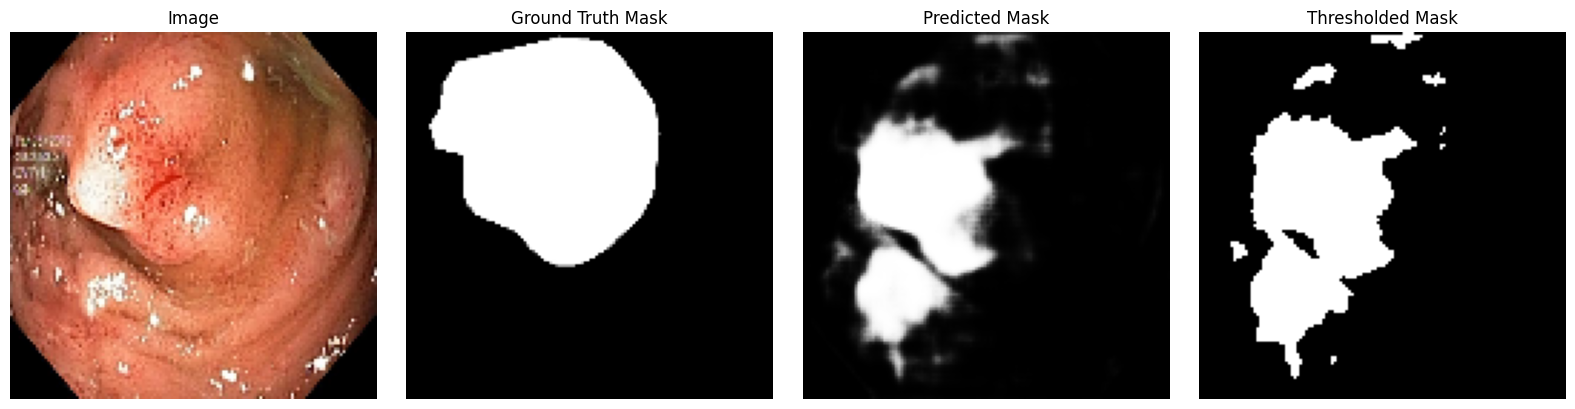

In [50]:
name = "cju0qkwl35piu0993l0dewei2.jpg"

image_path = "/content/drive/MyDrive/MachineLearning/PolypSegmentation/data/Kvasir-SEG/images/" + name
mask_path = "/content/drive/MyDrive/MachineLearning/PolypSegmentation/data/Kvasir-SEG/masks/" + name

# Read image and mask
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Image Preprocessing
image = cv2.resize(image, (128, 128))
image = image / 255.0

# Mask Preprocessing
mask = cv2.resize(mask, (128, 128))
mask = mask / 255.0

# Convert to tensor
image = torch.from_numpy(image).permute(2, 0, 1).float()
mask = torch.from_numpy(mask).unsqueeze(0).float()

pred_mask = inference(model, image.unsqueeze(0))

plot_image_mask(image, mask, pred_mask)

In [ ]:
%%writefile app.py

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split


# OpenCV
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

# PIL
from PIL import Image

# Streamlit 
import streamlit as st

#@title Streamlit App

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=output_dim,
                kernel_size=3,
                stride=stride,
                padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=output_dim,
                out_channels=output_dim,
                kernel_size=3,
                padding=1
            )
        )

        self.conv_skip = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=output_dim,
                kernel_size=3,
                stride=stride,
                padding=1
            ),
            nn.BatchNorm2d(output_dim)
        )

    def forward(self, x):
        x1 = self.conv_block(x)
        x2 = self.conv_skip(x)

        return x1 + x2


class UpSample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(UpSample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            in_channels=input_dim,
            out_channels=output_dim,
            kernel_size=kernel,
            stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

#@title ResUNet model
class ResUNet(nn.Module):
    def __init__(self, channel, filters = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=channel,
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=filters[0],
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            )
        )

        self.input_skip = nn.Sequential(
            nn.Conv2d(
                in_channels=channel,
                out_channels=filters[0],
                kernel_size=3,
                padding=1
            )
        )

        self.residual_conv1 = ResidualConv(filters[0], filters[1], stride=2, padding=1)
        self.residual_conv2 = ResidualConv(filters[1], filters[2], stride=2, padding=1)

        self.bridge = ResidualConv(filters[2], filters[3], stride=2, padding=1)

        self.upsample1 = UpSample(filters[3], filters[3], kernel=2, stride=2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], stride=1, padding=1)

        self.upsample2 = UpSample(filters[2], filters[2], kernel=2, stride=2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], stride=1, padding=1)

        self.upsample3 = UpSample(filters[1], filters[1], kernel=2, stride=2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], stride=1, padding=1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=filters[0],
                out_channels=1,
                kernel_size=1
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv1(x1)
        x3 = self.residual_conv2(x2)

        # Bridge
        x4 = self.bridge(x3)

        # Decoder
        x4 = self.upsample1(x4)

        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        # Output
        x11 = self.output_layer(x10)

        return x11

def inference(model, image):
    """
    Inference function for trained model.

    Args:
        model (torch.nn.Module): Trained model
        image (torch.Tensor): Input image tensor with shape [batch_size, 3, height, width] with pixel values in range [0, 1]
    """

    model.eval()

    with torch.no_grad():
        image = image.cuda()
        output = model(image)
        output = torch.sigmoid(output)

    return output
    
# Set page title
st.markdown("<h1 style='text-align: center; color: #0dbf8d;'>Polyp Segmentation using UNet</h1>", unsafe_allow_html=True)

# # Display project details
# st.markdown("<h2 style='color: #1488CC;'>Project Details</h2>", unsafe_allow_html=True)
# st.markdown("<h3>Architecture:</h3>", unsafe_allow_html=True)
# st.write("The UNet architecture is used for image segmentation.")
# st.markdown("<h3>Loss Function:</h3>", unsafe_allow_html=True)
# st.write("Dice Loss is used as the loss function for training the model.")
# st.markdown("<h3>Metrics:</h3>", unsafe_allow_html=True)
# st.write("Mean Dice, mIoU (mean Intersection over Union), and other relevant metrics are used for evaluation.")

# Upload image
st.markdown("<h2 style='color: #1488CC;'>Test Your Image</h2>", unsafe_allow_html=True)
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Read image by cv2
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Image preprocessing
    image = cv2.resize(image, (128, 128))
    image = image / 255.0

    # Convert image to tensor
    n_image = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)

    # Model 
    model = ResUNet(channel=3).cuda()
    model.load_state_dict(torch.load("/content/drive/MyDrive/MachineLearning/PolypSegmentation/models/unet_model_0.5818_0.4314.pt", map_location=torch.device('cuda')))

    # Inference
    mask = inference(model, n_image)

    mask = mask.squeeze(0).squeeze(0).cpu().numpy()

    # Threshold mask
    threshold = 0.55
    mask[mask >= threshold] = 1
    mask[mask < threshold] = 0

    # Convert mask to image
    mask = mask * 255.0
    mask = mask.astype(np.uint8)

    # Create two columns
    col1, col2 = st.columns(2)

    # Display the uploaded image in the first column
    with col1:
        st.markdown("<h5 style='text-align: center;'>Uploaded Image</h5>", unsafe_allow_html=True)
        st.image(image, caption="", use_column_width=True)

    # Display the predicted mask in the second column
    with col2:
        st.markdown("<h5 style='text-align: center;'>Predicted Mask</h5>", unsafe_allow_html=True)
        st.image(mask, caption="", use_column_width=True)